# HOMEWORK 2 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Unsupervised Deep Learning

## v1 is for trying with a 10 elements vector

### General overview
 In this homework you will learn how to implement and test neural network models for
solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen
before, the homework will be based on images of FashionMNIST. However, you can optionally explore
different image collections (e.g., Caltech or Cifar) or other datasets based on your interests. The basic tasks
for the homework will require to test and analyze the convolutional autoencoder implemented during the
Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar
performance considering the relatively small size of the FashionMNIST images. As for the previous
homework, you should explore the use of advanced optimizers and regularization methods. Learning
hyperparameters should be tuned using appropriate search procedures, and final accuracy should be
evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and
variational / adversarial architectures.

## Convolutional autoencoder
- implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and
some examples of image reconstruction; explore advanced optimizers and regularization methods

In [18]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

In [19]:
## Dataset
# training and validation will be performed on the training dataset
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True)
# test dataset will only be used for evaluating final model performance
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, download=True)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
num_labels = len(label_names)

In [20]:
## Data transformation
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform


In [21]:
## Model definition
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            #third linear layer
            nn.Linear(in_features=32, out_features=encoded_space_dim)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        ) 
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
        

In [22]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for (image_batch, _) in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add loss to the list
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    #print(f"Batch Train loss: {train_loss}")
    return train_loss

### Testing function
def validate_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for (image_batch, _) in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        #print(f"Batch Validation loss: {val_loss}")
    return val_loss.item()

In [23]:
#useful functions
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.close()

def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.reset_parameters()

## Optimize hyperparameters
- 1 pt: optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna)
- final accuracy should be evaluated using a cross-validation setup (concatenate training and test set like in here, than evaluate accuracy for each fold and take the avg https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/)

In [24]:
#decide to load or not the pretrained model
load_good_model = True

pretrained_encoder_path = "good_models/encoder_0_final10_9.pt"
pretrained_decoder_path = "good_models/decoder_0_final10_9.pt"

#create a folder called training to save the model
if not load_good_model:
    if not os.path.exists('data/training'):
        os.makedirs('data/training')
    #clear the training folder
    if os.listdir('data/training'):
        for f in os.listdir('data/training'):
            os.remove(os.path.join('data/training', f))

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu") #for debugging
print(f'Selected device: {device}')

Selected device: cuda


In [25]:
#create param combinations for grid search parameters tuning
lr = 1e-3
encoded_space_dim = 10
param_combinations = [[lr, 0, 0, encoded_space_dim]]#,[1e-4, 0,0, 2], [1e-3, 0, 0, 8], [1e-4, 0,0, 8]]
print(len(param_combinations))

1


In [26]:
### Main block
k_folds = 2
num_epochs = 10
def train_loop(param_combinations, k_folds, num_epochs, train_dataset, device = "cuda"):

    train_losses = []
    val_losses = []

    encoder,decoder = Encoder(2), Decoder(2)

    for comb, params in enumerate(param_combinations):
        print("_____________________________________________")
        print(f"Parameter combination {comb}: {params}")
        lr, par2, par3, encoded_space_dim = params

        # initialize models
        enc = Encoder(encoded_space_dim)
        dec = Decoder(encoded_space_dim)
        #reset weights
        enc.apply(reset_weights)
        dec.apply(reset_weights)
        # initialize optimizer
        params_to_optimize = [
            {'params': enc.parameters()},
            {'params': dec.parameters()}
        ]
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
        # initialize loss function
        loss_fn = nn.MSELoss()
        # move to device
        enc.to(device)
        dec.to(device)

        ## train the model
        # perform cross validation 
        kfold = KFold(n_splits=k_folds, shuffle=True)
        #initialize trainining and validation losses
        comb_train_losses = np.zeros(num_epochs)
        comb_val_losses = np.zeros(num_epochs)
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(train_dataset)):
            #print(f"Fold {fold}")
            #reset weights
            enc.apply(reset_weights)
            dec.apply(reset_weights)
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_ids)
            # dataloaders
            train_dataloader = DataLoader(train_dataset, batch_size=256, sampler=train_subsampler) 
            validation_dataloader = DataLoader(train_dataset, batch_size=256, sampler=validation_subsampler) 
            # train the model
            i_train_losses = []
            i_val_losses = []
            for epoch in tqdm(range(num_epochs)):
                #print(f"Epoch {epoch+1}/{num_epochs}")
                #train
                epoch_train_loss = train_epoch(enc, dec, device, train_dataloader, loss_fn, optim)
                #validate
                epoch_val_loss = validate_epoch(enc, dec, device, validation_dataloader, loss_fn)
                # store losses
                i_train_losses.append(epoch_train_loss)
                i_val_losses.append(epoch_val_loss)
                # # save model
                # torch.save(enc.state_dict(), f"data/training/encoder_{comb}_{fold}_{epoch}.pt")
                # torch.save(dec.state_dict(), f"data/training/decoder_{comb}_{fold}_{epoch}.pt")
            
            comb_train_losses += np.array(i_train_losses)/k_folds
            comb_val_losses += np.array(i_val_losses)/k_folds
        
        plot_losses(comb_train_losses, comb_val_losses)
        # train and validation loss for paramters combination
        comb_train_loss = comb_train_losses[-1] # last epoch
        comb_val_loss = comb_val_losses[-1] # last epoch
        print(f"\n\n\nCombination {comb} Train loss: {comb_train_loss}")
        print(f"Combination {comb} Validation loss: {comb_val_loss}")

        # train the model on all the trainign data
        enc.apply(reset_weights)
        dec.apply(reset_weights)
        for epoch in tqdm(range(num_epochs)):
            #print(f"Epoch {epoch+1}/{num_epochs}")
            #train
            epoch_train_loss = train_epoch(enc, dec, device, train_dataloader, loss_fn, optim)
            encoder = enc
            decoder = dec
            # save model
            torch.save(enc.state_dict(), f"data/training/encoder_{comb}_final_{epoch}.pt")
            torch.save(dec.state_dict(), f"data/training/decoder_{comb}_final_{epoch}.pt")



    # save losses
    with open(f"data/training/losses_{comb}.pkl", 'wb') as f:
        pickle.dump([train_losses, val_losses], f)

    return encoder, decoder

        

In [27]:
# select best combination #### IMPLEMENT THIS ################################
encoded_space_dim = 10

In [28]:
# execute the training loop
encoder, decoder = Encoder(encoded_space_dim), Decoder(encoded_space_dim)
if not load_good_model:
    encoder, decoder = train_loop(param_combinations, k_folds, num_epochs, train_dataset)
else:
    #load a good model from the good_models folder
    encoder.load_state_dict(torch.load(pretrained_encoder_path))
    decoder.load_state_dict(torch.load(pretrained_decoder_path))
    print("Loaded pretrained model")
    

Loaded pretrained model


In [29]:
### Test the model
# calculate loss on training set
encoder, decoder = encoder.to(device), decoder.to(device)
train_loss = validate_epoch(encoder, decoder, device, DataLoader(train_dataset, batch_size=60000), nn.MSELoss())
print(f"Train loss: {train_loss}")
# calculate loss on test set
test_loss = validate_epoch(encoder, decoder, device, DataLoader(test_dataset, batch_size=20000), nn.MSELoss())
print(f"Test loss: {test_loss}")

Train loss: 0.038053229451179504
Test loss: 0.03786986693739891


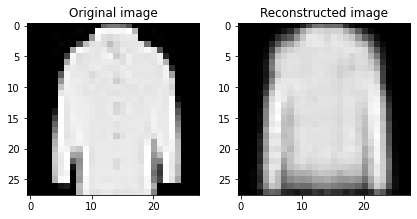

In [30]:
### Test on a single example
def test_on_example(n_example, test_dataset=test_dataset, decoder=decoder, encoder=encoder):
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[n_example][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()
    plt.pause(0.1)
    plt.show()
    plt.close()

test_on_example(14)

## Supervised fine tuning and comparison with supervised methods
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare
classification accuracy and learning speed with results achieved in Homework 1

In [31]:
# function to get model accuracy
def get_accuracy(encoder, dataset):
    this_dataloader = DataLoader(dataset, batch_size=20000)
    correct = 0
    total = 0
    with torch.no_grad():
        for (data, label) in tqdm(this_dataloader):
            # target = onehot encoding of label
            #target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = encoder(data)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum() #.item()
            # Add to the total number of predictions
            total += data.shape[0]
    return correct/total

In [32]:
torch.manual_seed(0)
mse_multiplier = 8

#load model
if load_good_model:
    decoder.load_state_dict(torch.load('good_models/decoder10_20.pt'))
    encoder.load_state_dict(torch.load('good_models/encoder10_20.pt'))
    print("Loaded pretrained models")
else:
    # dataloader
    train_dataloader_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
    #loss
    loss_fn_2 = nn.CrossEntropyLoss()
    dec_loss_fn = nn.MSELoss()
    #optimizer
    params_to_optimize = [
                {'params': encoder.parameters()},
                {'params': decoder.parameters()}
            ]
    optimizer_2 = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
    # to gpu
    encoder.to(device)
    decoder.to(device)

    #train loop
    step2_num_epochs = 20
    target_losses = []
    reconstruction_losses = []
    for epoch in range(step2_num_epochs):
        print(f"Epoch {epoch+1}/{step2_num_epochs}")
        encoder.train()
        decoder.train()
        epoch_losses2 = []
        dec_losses = []
        for (data, label) in tqdm(train_dataloader_2):
            # Zero the gradients
            optimizer_2.zero_grad()
            ## DECODER + SINGLE LAYER MATCHER TRAINING
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder to encode the data
            encoded_data = encoder(data)
            assert encoded_data.shape == target.shape
            # Compute the loss
            loss2 = loss_fn_2(encoded_data, target)
            # Compute the gradients
            loss2.backward(retain_graph=True)
            ## DECODER TRAINING
            # Compute the output
            decoded_data = decoder(encoded_data)
            # Compute the loss
            dec_loss = mse_multiplier*dec_loss_fn(decoded_data, data) # for more weightage
            # Compute the gradients
            dec_loss.backward()

            # Update the weights
            optimizer_2.step()

            #batch loss
            loss_batch2 = loss2.item()
            epoch_losses2.append(loss_batch2)
            dec_loss_batch = dec_loss.item()
            dec_losses.append(dec_loss_batch)

        # Return the average training loss
        epoch_loss2 = np.mean(epoch_losses2)
        print(f"target loss: {epoch_loss2}")
        target_losses.append(epoch_loss2)
        dec_loss = np.mean(dec_losses)
        print(f"reconstruction loss (x{mse_multiplier}): {dec_loss}")
        reconstruction_losses.append(dec_loss)

    #plot losses
    plt.plot(target_losses)
    plt.plot(reconstruction_losses)
    plt.legend(['target loss', 'reconstruction loss'])
    plt.show()

#accuracy
step_2_train_accuracy = get_accuracy(encoder, train_dataset)
step_2_test_accuracy = get_accuracy(encoder, test_dataset)
#print train and test accuracy with 3 decimal places
print(f"Train Accuracy WITH Decoder tuning: {round(step_2_train_accuracy.item()*100, 1)} %")
print(f"Test Accuracy WITH Decoder tuning: {round(step_2_test_accuracy.item()*100, 1)} %")

Loaded pretrained models


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Train Accuracy WITH Decoder tuning: 87.7 %
Test Accuracy WITH Decoder tuning: 86.1 %


In [33]:
# save model
if not load_good_model:
    torch.save(decoder.state_dict(), f'good_models/decoder10_{step2_num_epochs}.pt')
    torch.save(encoder.state_dict(), f'good_models/encoder10_{step2_num_epochs}.pt')

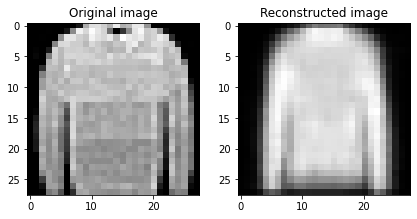

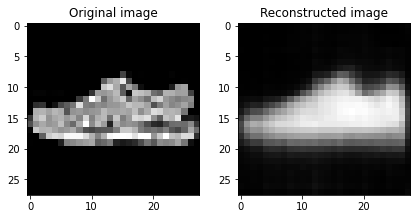

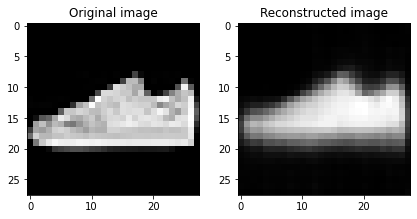

In [39]:
#test on examples
for i in range(20,23):
    test_on_example(i)

## Latent space exploration and generation of new samples
- 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

## PCA

In [47]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
import plotly.express as px
fig2a = px.scatter(encoded_samples_reduced_PCA, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig2a.show()

pca3 = PCA(n_components=3)
encoded_samples_reduced_PCA3 = pca3.fit_transform(encoded_samples)
fig2b = px.scatter_3d(encoded_samples_reduced_PCA3, x=0, y=1, z=2, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig2b.show()


100%|██████████| 10000/10000 [00:14<00:00, 672.54it/s]


(10000, 2)


(10000, 3)


## t-SNE

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
fig3a = px.scatter(encoded_samples_reduced_TSNE, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig3a.show()

tsne3 = TSNE(n_components=3)
encoded_samples_reduced_TSNE3 = tsne3.fit_transform(encoded_samples)
fig3b = px.scatter_3d(encoded_samples_reduced_TSNE3, x=0, y=1, z=2,
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig3b.show()

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



evident how the TSNE is nonlinear, coat and pullover are very hard to distinguish.

## Generate new samples
New samples are generated in the case of 2 hidden dimensions, since it's much more intuitive to pick samples

## Variational autoencoder / GAN / SimCLR
- 2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR

Implemented in a new notebook

# MISSING:
# - ADVANCED OPTIMIZERS AND REGULARIZATION
# - PARAMETERS GRID SEARCH
# - FINAL PERFORMANCES EVALUATED IN A CROSS VALIDATION SETUP